In [1]:
#Gather All Imports required for the project
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import time
from sklearn.svm import LinearSVC
from moviepy.editor import VideoFileClip


%matplotlib inline

In [2]:
# Basic functions provided on Udacity's course to extract features.

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [3]:
# Set up HOG parameters, select YCrCb as SVC fit with this color space gave +3-4% higher accuracy than RGB or HSV

color_space = 'YCrCb'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_feat= True
spatial_feat= True
hist_feat= True
hog_channel = 'ALL'
# Bin spatial parameters
spatial_size = (32,32)
# Histogram parameters
hist_bins = 32


In [4]:
##Read in the training data
nv_images_1 = glob.glob('./training_images/non-vehicles/Extras/*.png')
nv_images_2 = glob.glob('./training_images/non-vehicles/GTI/*.png')

v_images_1 = glob.glob('./training_images/vehicles/GTI_Far/*.png')
v_images_2 = glob.glob('./training_images/vehicles/GTI_Left/*.png')
v_images_3 = glob.glob('./training_images/vehicles/GTI_MiddleClose/*.png')
v_images_4 = glob.glob('./training_images/vehicles/GTI_Right/*.png')
v_images_5 = glob.glob('./training_images/vehicles/KITTI_extracted/*.png')

cars = []
notcars = []

for image in nv_images_1:
    notcars.append(image)
for image in nv_images_2:
    notcars.append(image)

for image in v_images_1:
    cars.append(image)
for image in v_images_2:
    cars.append(image)
for image in v_images_3:
    cars.append(image)
for image in v_images_4:
    cars.append(image)
for image in v_images_5:
    cars.append(image)

No of car images: 8792 No of non car images: 8968


Text(0.5,1,'Example Not-car Image')

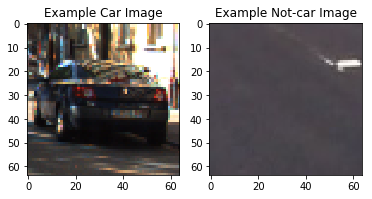

In [5]:
#Verify training data for car & Not Car images

print('No of car images:',len(cars), 'No of non car images:',len(notcars))
    
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

Text(0.5,1,'Cb')

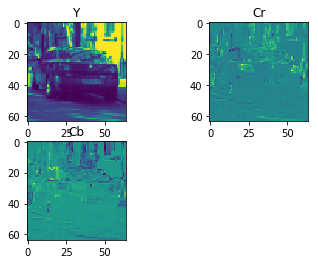

In [6]:
#Verify YCrCb space
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
ycrcb= cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)

# Plot the examples
fig = plt.figure()
plt.subplot(221)
plt.imshow(ycrcb[:,:,0])
plt.title('Y')
plt.subplot(222)
plt.imshow(ycrcb[:,:,1])
plt.title('Cr')
plt.subplot(223)
plt.imshow(ycrcb[:,:,2])
plt.title('Cb')

Text(0.5,1,'HOG Visualization')

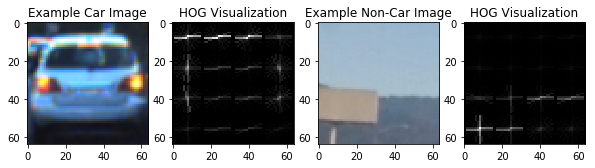

In [7]:
# Generate a random index to look at a car image and it's HOG representation
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
ycrcb= cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
gray = cv2.cvtColor(ycrcb, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Generate a random index to look at a non-car image
ind2 = np.random.randint(0, len(notcars))
# Read in the image
image2 = mpimg.imread(notcars[ind2])
gray = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
# Define HOG parameters

# Call our function with vis=True to see an image output
features2, hog_image2 = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.figure(figsize=(10,10))
plt.subplot(141)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(142)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(143)
plt.imshow(image2, cmap='gray')
plt.title('Example Non-Car Image')
plt.subplot(144)
plt.imshow(hog_image2, cmap='gray')
plt.title('HOG Visualization')

cars length 8792 non car length 8968
Total samples: 17760 feature vector length (4356,)


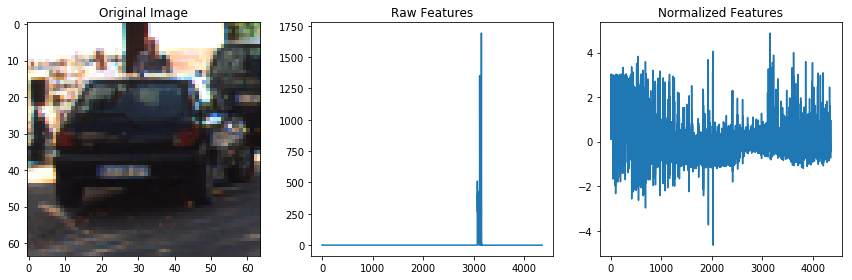

In [8]:
#Extract car & non car image features, normalize the  values to avoid drastic variations
print('cars length',len(cars), 'non car length', len(notcars))  

car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel='ALL',
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel='ALL',
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

#scaled_feature_pickle={}
#scaled_feature_pickle['scaled_X']=scaled_X
#pickle.dump(scaled_feature_pickle, open( "scaled_feature_pickle.p", "wb" ) )
#print('saved scaled feature vector scaled_X')
print('Total samples:', len(scaled_X),'feature vector length', scaled_X[0].shape)

In [9]:
# Fit a Linear SVC model to the normalized data
print('Total samples:', len(X),'feature vector length', X[0].shape)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('y labels length', len(y))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
#X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
#X_train = X_scaler.transform(X_train)
#X_test = X_scaler.transform(X_test)

#print('Using spatial binning of:',spatial,
#    'and', histbin,'histogram bins')

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Total samples: 17760 feature vector length (4356,)
y labels length 17760
10.16 Seconds to train SVC...
Test Accuracy of SVC =  0.9907
My SVC predicts:  [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.]
0.00175 Seconds to predict 10 labels with SVC


In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
# Implement a sliding window mehod that can step over the entire image, extract HOG feature vector within that window
# and run a classifier prediction on the feature vector to decide whether it's a car image or non car image
# Once a car is deteted within the window, draw a rectangle around that window.

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    #print('in find_cars')
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch=img_tosearch
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    #ctrans_tosearch = ctrans_tosearch.astype(np.float32)/255
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    #print(nfeat_per_block)
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    bbox_list=[]

    #print('nxsteps',nxsteps,'nysteps',nysteps)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            #print('current nx,ny',xb,yb)
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #print('Hog features shape',hog_features.shape)
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            #print('Spatial features shape',spatial_features.shape)
            #print('Hist features shape',hist_features.shape)
            #print('HOG features shape',hog_features.shape)
            
            #print('Total features shape',hist_features.shape+spatial_features.shape+hog_features.shape)
            #,'Hist features',hist_features.shape,'Hog features',hog_features.shape)
            #print(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1).shape)
            # Scale features and make a prediction
            #test=np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1)
            #test=hog_features
            #print('np.hstack shape',test.shape, len(test[0]))
            
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_features = np.hstack((spatial_features, hist_features, hog_features))
            #print('hpstack',test_features.shape)
            test_features =(test_features).reshape(1,-1)
            #print('reshape',test_features.shape)
            test_features =X_scaler.transform(test_features)
            #print('scaler trnsform',test_features.shape)
            #test_features = X_scaler.transform(test.reshape(1, -1))
            
            #print('feature vector length',len(test[0]))
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            #Use this IF ststement to print out all windows
            #if test_prediction == 1 or test_prediction == 0 :
            if test_prediction == 1 :
                  
                xbox_left = np.int(xleft*scale)
                #print('ytop',ytop, 'scale',scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, bbox_list
print('...')

...


[]
[]
[]
[]
[]
[((864, 400), (960, 496))]
[]


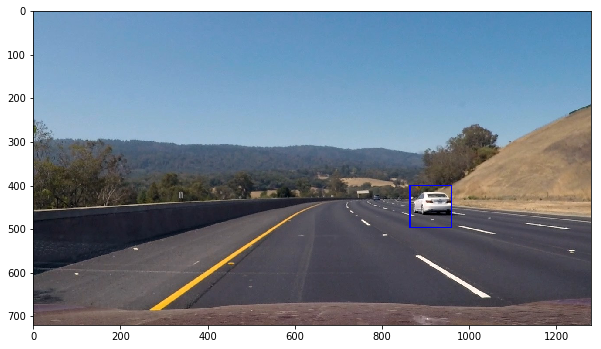

In [17]:
# test the Find car function, scale windowed sections of the image at various multiples
# The farther the car, the smaller it would appear, so scale the mid part of the image with smaller windows
# After experimenting, HOG features alone were pretty good at detecting cars
test_img = mpimg.imread('./test_images/test3.jpg')
all_rectangles = []
spatial_size = (32,32)
# Histogram parameters
hist_bins = 32

ystart = 400
ystop = 500
scale = 4.0
img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
all_rectangles.append(rectangles)

ystart = 400
ystop = 500
scale = 3.5
img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
all_rectangles.append(rectangles)

ystart = 400
ystop = 500
scale = 3.0
img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
all_rectangles.append(rectangles)

ystart = 400
ystop = 600
scale = 2.5
img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
all_rectangles.append(rectangles)

ystart = 400
ystop = None
scale = 2.0
img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
all_rectangles.append(rectangles)

ystart = 400
ystop = None
scale = 1.5
img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
all_rectangles.append(rectangles)

ystart = 400
ystop = None
scale = 1.0
img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
all_rectangles.append(rectangles)
#test_img_rects = draw_boxes(test_img, all_rectangles, color='random', thick=2)
#print(len(test_img_rects), 'rectangles found in image')
for bbox in all_rectangles:
    print(bbox)
    test_img_rects = draw_boxes(test_img, bbox, color=(0, 0, 255), thick=2)
    test_img=test_img_rects
#print(test_img_rects)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

In [18]:
# Build a pipeline to test basic rectangle detection
def pipeline(test_img):
    all_rectangles = []
    # HOG parameters

    # Set up HOG parameters, select YCrCb as SVC fit with this color space gave +3-4% higher accuracy than RGB or HSV

    color_space = 'YCrCb'
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_feat= True
    spatial_feat= True
    hist_feat= True
    hog_channel = 'ALL'
    # Bin spatial parameters
    spatial_size = (32,32)
    # Histogram parameters
    hist_bins = 32

    ystart = 400
    ystop = 500
    scale = 4.0
    img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
    all_rectangles.append(rectangles)

    ystart = 400
    ystop = 500
    scale = 3.75
    img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
    all_rectangles.append(rectangles)

    ystart = 400
    ystop = 500
    scale = 3.5
    img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
    all_rectangles.append(rectangles)
    
    ystart = 400
    ystop = 500
    scale = 3.0
    img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
    all_rectangles.append(rectangles)

    ystart = 400
    ystop = 600
    scale = 2.75
    img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
    all_rectangles.append(rectangles)
    
    ystart = 400
    ystop = 600
    scale = 2.5
    img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
    all_rectangles.append(rectangles)

    ystart = 400
    ystop = None
    scale = 2.25
    img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
    all_rectangles.append(rectangles)
    
    ystart = 400
    ystop = None
    scale = 2.0
    img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
    all_rectangles.append(rectangles)

    ystart = 400
    ystop = None
    scale = 1.5
    img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
    all_rectangles.append(rectangles)

    ystart = 400
    ystop = None
    scale = 1.25
    img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
    all_rectangles.append(rectangles)
    
    ystart = 400
    ystop = None
    scale = 1.0
    img,rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
    all_rectangles.append(rectangles)
    #test_img_rects = draw_boxes(test_img, all_rectangles, color='random', thick=2)
    #print(len(test_img_rects), 'rectangles found in image')
    for bbox in all_rectangles:
        #print(bbox)
        test_img_rects = draw_boxes(test_img, bbox, color=(0, 0, 255), thick=2)
        test_img=test_img_rects
    return test_img, all_rectangles


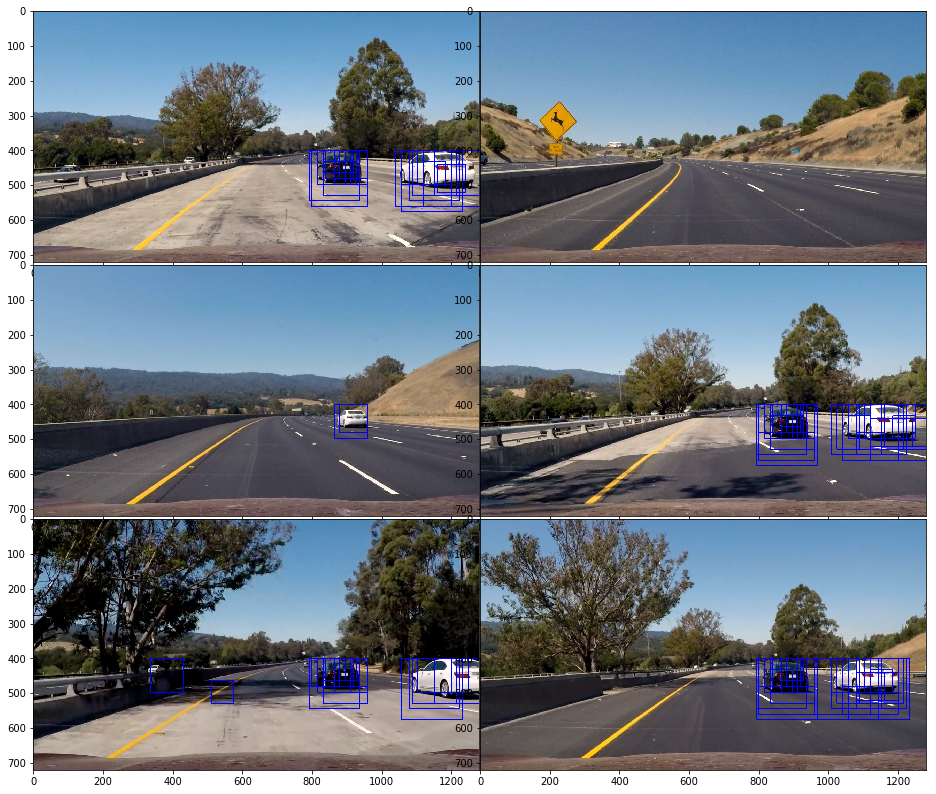

In [19]:
# Run the pipeline on multiple images
test_images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    test_img=mpimg.imread(im)
    out,rects=pipeline(test_img)
    #print(len(rectangles), 'rectangles found in image')
    axs[i].imshow(out)
    #axs[i].imshow((mpimg.imread(im)))

In [20]:
# Add a Heat map functionality to cut out outlier rectangles/false positives
def add_heat(heatmap, bbox_list):
    #print(bbox_list)
    # Iterate through list of bboxes
    #print(bbox_list)
    for box in bbox_list:
        if(not box):
            print('empty list')
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        else:
            #print(box)
            #print(box[0][1],box[1][1], box[0][0], box[1][0])
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            

    # Return updated heatmap
    return heatmap

print('...')

...


...


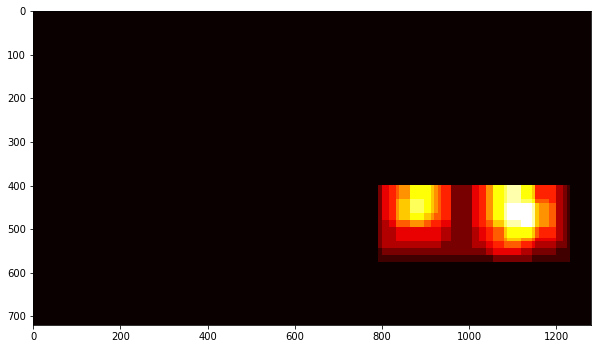

In [21]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
for rect in rects:
    heatmap_img = add_heat(heatmap_img, rect)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

In [22]:
#Define a threshold function to filter out false positives
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print('...')

...


...


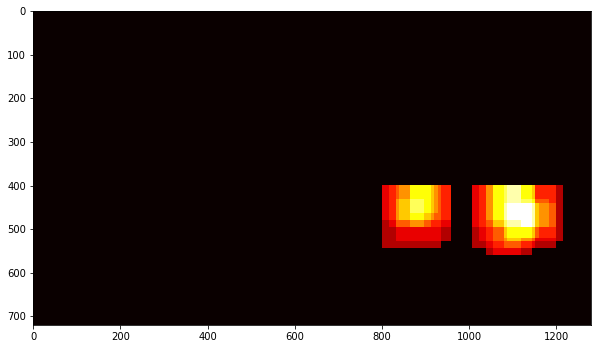

In [23]:
# Test the heatmap threshold function
heatmap_img = apply_threshold(heatmap_img, 2)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

2 cars found


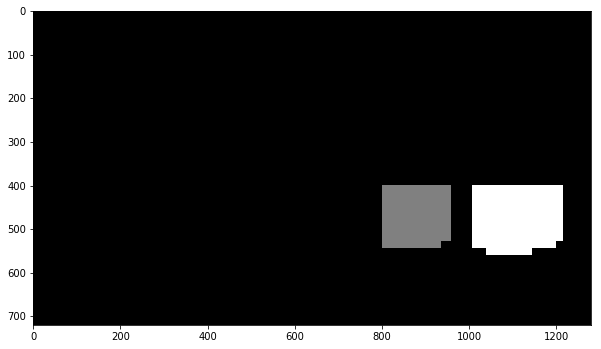

In [24]:
# Use the Scipy Label function to assign unique values to heat map objects
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

...


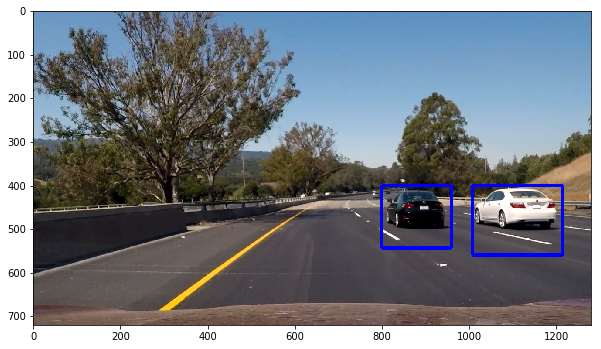

In [25]:
#Combine to form a bounding box
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
print('...')

In [26]:
# Build the final pipeline which combines the basic rectangle detection pipeline with the heatmap functionality
def pipeline_final(test_img):
    out,rects=pipeline(test_img)
    
    heatmap_img = np.zeros_like(test_img[:,:,0])
    for rect in rects:
        heatmap_img = add_heat(heatmap_img, rect)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)

    return draw_img

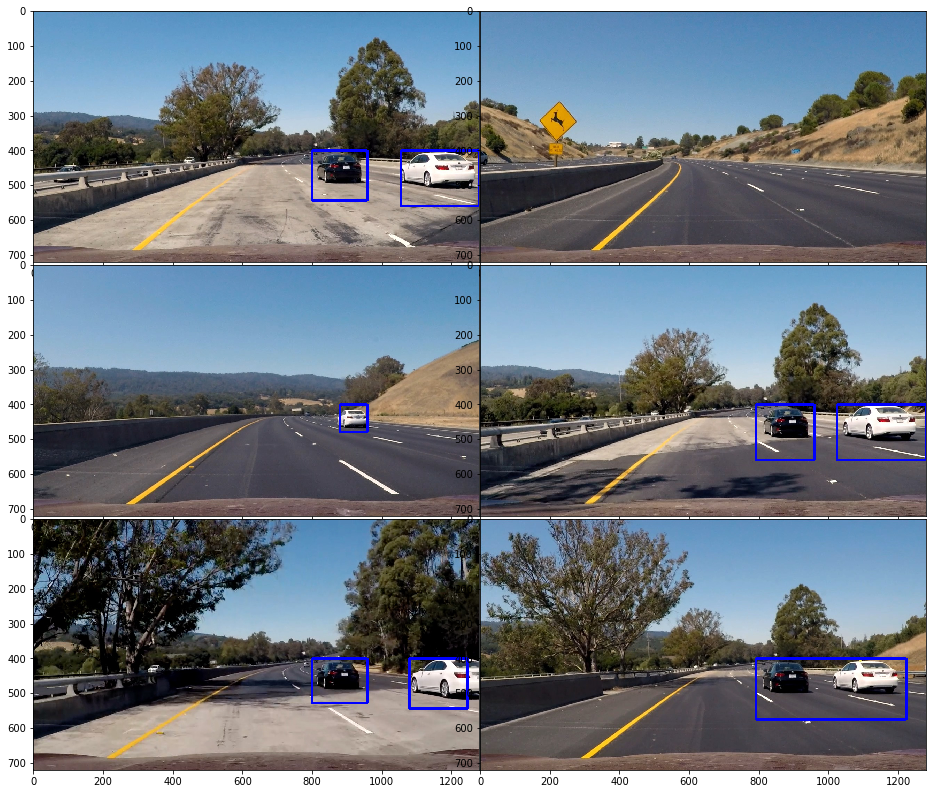

In [27]:
#Test the pipeline on all test images
test_images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    test_img=mpimg.imread(im)
    out=pipeline_final(test_img)
    #print(len(rectangles), 'rectangles found in image')
    axs[i].imshow(out)
    #axs[i].imshow((mpimg.imread(im)))

In [28]:
#Run the video through the final pipeline
test_out_file = 'project_video_out2.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(pipeline_final)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out2.mp4
[MoviePy] Writing video project_video_out2.mp4


100%|█████████▉| 1260/1261 [30:13<00:01,  1.41s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out2.mp4 

CPU times: user 27min 32s, sys: 2min 24s, total: 29min 56s
Wall time: 30min 15s


In [ ]:
test_img = mpimg.imread('./test_images/test1.jpg')
print(test_img.dtype)
print(test_img[:,:,0])

test_img=cv2.cvtColor(test_img, cv2.COLOR_RGB2YCrCb)
print(test_img.dtype)
print(test_img[:,:,0])